In [1]:
import joblib
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import BUFKIT_BUFR_Parser as BUFR
from shapely.geometry import Point, LineString
from datetime import datetime
from metpy.units import units
from metpy.plots import USCOUNTIES

In [3]:
# Water data
ice_cover_ontario = 0.0
ice_cover_huron = 0.0
ice_cover_erie = 0.0
water_temperature = 11.8 * units.degC

In [ ]:
# Model parameters
station = 'LO1'
model   = 'RAP'
run     = datetime(2020, 11, 1, 18)

# Get BUFR data
BUFR_data=BUFR.getBUFR_data(station, model, time=run, sounding=True, surface=False)

# Get model profiles
dataset = pd.DataFrame()
profiles = model_data = BUFR_data['sounding']['PROFILE']
for (i, model_data) in zip(range(len(profiles)), profiles):

    # Added desired levels
    desired_levels = [925, 850, 700, 500]
    for level in desired_levels:
        row = [{'PRES':level, 'TMPC':np.nan, 'TMWC':np.nan, 'DWPC':np.nan, 'THTE':np.nan, 'DRCT':np.nan, 'SKNT':np.nan, 'OMEG':np.nan, 'CFRL':np.nan, 'HGHT':np.nan}]
        model_data=model_data.append(row, ignore_index=True)   

    # Sort and interpolate missing values
    model_data = model_data.sort_values(['PRES'], ascending=False)
    model_data = model_data.interpolate()

    # Select only desired levels
    model_data = model_data[model_data.PRES.isin(desired_levels)]

    # Pull model variables
    z_data = model_data.HGHT.to_list() * BUFR.getParameterUnit('HGHT')
    p_data = model_data.PRES.to_list() * BUFR.getParameterUnit('PRES')
    T_data = model_data.TMPC.to_list() * BUFR.getParameterUnit('TMPC')
    Td_data = model_data.DWPC.to_list() * BUFR.getParameterUnit('TMPC')
    WD_data = model_data.DRCT.to_list() * BUFR.getParameterUnit('DRCT')
    WS_data = model_data.SKNT.to_list() * BUFR.getParameterUnit('SKNT')
    u_data, v_data = mpcalc.wind_components(WS_data, WD_data)

    # Derive data and build dataset
    inital_data = {'DateTime':BUFR_data['sounding'].TIME[i], 'OntarioT':water_temperature.magnitude, 'OntarioIce':ice_cover_ontario, 'HuronIce':ice_cover_huron, 'ErieIce':ice_cover_erie}
    df = pd.DataFrame([inital_data])
    for i, z, p, T, Td, u, v in zip(range(len(z_data)), z_data, p_data, T_data, Td_data, u_data, v_data):

        # Add height
        df[f'{int(p.magnitude)}_hPa_z'] = [z.magnitude]

        # Add air temperature
        df[f'{int(p.magnitude)}_hPa_T'] = [T.magnitude]

        # Calculate lapse-rate from water if > 500 hPa
        if p > (500*units.hPa):
            gamma_water = -((T-water_temperature)/z).to('degC/km')
            df[f'{int(p.magnitude)}_hPa_Γwater'] = [gamma_water.magnitude]

        # Calculate RH
        rh = mpcalc.relative_humidity_from_dewpoint(T, Td)
        df[f'{int(p.magnitude)}_hPa_RH'] = [rh.magnitude*100]

        # Add u and v components
        df[f'{int(p.magnitude)}_hPa_u'] = [u.magnitude]
        df[f'{int(p.magnitude)}_hPa_v'] = [v.magnitude]

        # Derive bulk shear (except at first level)
        if p != p_data[0]:
            u_shear, v_shear = mpcalc.bulk_shear(p_data, u_data, v_data, bottom=p_data[0], depth=p_data[0]-p_data[i])
            bulk_shear = mpcalc.wind_speed(u_shear, v_shear)
            df[f'{int(p_data[0].magnitude)}-{int(p.magnitude)}_hPa_shear'] = [bulk_shear.magnitude]
            
    # Append to main dataset
    dataset = dataset.append(df)

In [60]:
dataset

,DateTime,OntarioT,OntarioIce,HuronIce,ErieIce,925_hPa_z,925_hPa_T,925_hPa_Γwater,925_hPa_RH,925_hPa_u,...,700_hPa_RH,700_hPa_u,700_hPa_v,925-700_hPa_shear,500_hPa_z,500_hPa_T,500_hPa_RH,500_hPa_u,500_hPa_v,925-500_hPa_shear
0,2020-11-01 18:00:00,11.8,0.0,0.0,0.0,597.055,3.49,13.918316,99.156798,30.881546,...,84.501034,29.302882,40.383811,23.731820,5383.305,-25.51,30.547398,17.463783,70.226131,55.177852
0,2020-11-01 19:00:00,11.8,0.0,0.0,0.0,593.255,2.29,16.030206,96.632709,29.921557,...,98.997822,22.664246,36.912344,25.130818,5356.425,-25.36,21.637543,18.372565,71.868778,60.135955
0,2020-11-01 20:00:00,11.8,0.0,0.0,0.0,594.485,2.84,15.071869,80.979575,28.656440,...,83.506236,22.544881,51.812579,38.311032,5330.555,-26.41,9.457389,21.572281,73.723680,60.150142
0,2020-11-01 21:00:00,11.8,0.0,0.0,0.0,594.675,3.14,14.562576,70.655811,34.768573,...,64.321467,30.522287,45.464795,31.860190,5307.555,-27.51,7.106453,15.190399,68.946441,58.434956
0,2020-11-01 22:00:00,11.8,0.0,0.0,0.0,592.400,2.04,16.475354,71.964745,33.314100,...,82.093939,31.965334,42.250418,32.080924,5285.205,-27.71,3.818947,18.892264,62.951235,54.689194
0,2020-11-01 23:00:00,11.8,0.0,0.0,0.0,779.680,-2.01,17.712395,99.044937,36.521213,...,98.644094,20.485968,17.664303,18.165148,5267.715,-29.36,5.662521,21.493402,48.320357,41.973342
0,2020-11-02 00:00:00,11.8,0.0,0.0,0.0,780.950,-1.66,17.235418,72.742105,30.981244,...,93.196185,25.507728,20.944829,6.863404,5255.370,-30.66,20.607237,21.456337,30.694105,16.842222
0,2020-11-02 01:00:00,11.8,0.0,0.0,0.0,777.875,-2.51,18.396272,77.423567,32.929145,...,78.822549,36.339898,0.608938,18.263211,5248.350,-30.31,35.595757,23.915805,27.008145,12.359871
0,2020-11-02 02:00:00,11.8,0.0,0.0,0.0,586.195,-1.31,22.364572,95.648494,30.204543,...,71.603461,31.941845,-2.009611,21.713027,5240.045,-30.31,40.787713,25.100278,23.008228,6.118846
0,2020-11-02 03:00:00,11.8,0.0,0.0,0.0,585.955,-1.16,22.117739,99.196981,28.785932,...,60.939645,30.979388,-0.194652,17.263716,5235.620,-31.91,54.876973,22.441264,16.861630,6.345027


In [2]:
# Load in model 
ai_model=joblib.load('../models/LES_Band_Position_Model_KNN(n=2)_LO1_LatLon')
ai_model

KNeighborsRegressor(n_neighbors=2)

In [42]:
# Get predictions from machine learning model
predictions = pd.DataFrame()
for (time, inputData) in zip(dataset.DateTime, dataset.values[:, 1:]):
    
    # Get model prediction
    prediction=ai_model.predict([inputData])[0]

    # Generate coordiante list from prediction
    data={'DateTime':time}
    for i in range(0, len(prediction), 2):
        
        lat, lon = prediction[i], prediction[i+1]       
        data[f'Point{int(i/2)}'] = Point(lon, lat)
                      
    predictions = predictions.append([data], ignore_index=True)
    
predictions

,DateTime,Point0,Point1,Point2
0,2020-11-01 18:00:00,POINT (-76.61233550000001 43.6283455),POINT (-75.83829377947072 43.56241074378509),POINT (-75.02676 43.4920385)
1,2020-11-01 19:00:00,POINT (-76.87118150000001 43.311371),POINT (-76.2999306136654 43.0394697752235),POINT (-75.6711195 42.7249565)
2,2020-11-01 20:00:00,POINT (-76.70455550000001 43.68265150000001),POINT (-76.1211810742129 43.64646538230885),POINT (-75.56919450000001 43.5901755)
3,2020-11-01 21:00:00,POINT (-76.31605500000001 44.0388795),POINT (-75.54067729556431 44.27337284277559),POINT (-74.80218500000001 44.5459175)
4,2020-11-01 22:00:00,POINT (-76.26643749999999 44.034996),POINT (-75.84211865869564 44.18506324782609),POINT (-75.471321 44.325792)
5,2020-11-01 23:00:00,POINT (-76.27697000000001 43.926632),POINT (-75.28301382017675 44.01945912054492),POINT (-74.21686600000001 44.08740800000001)
6,2020-11-02 00:00:00,POINT (-76.17398849999998 43.8266505),POINT (-75.4519853506973 44.07862090101177),POINT (-74.7598265 44.38052200000001)
7,2020-11-02 01:00:00,POINT (-76.1839445 43.7069),POINT (-75.35807244012605 43.76807968172269),POINT (-74.44266900000001 43.806738)
8,2020-11-02 02:00:00,POINT (-76.17787150000001 43.8542445),POINT (-75.38014532960526 44.02324144407895),POINT (-74.56127549999999 44.276825)
9,2020-11-02 03:00:00,POINT (-76.17787150000001 43.8542445),POINT (-75.38014532960526 44.02324144407895),POINT (-74.56127549999999 44.276825)


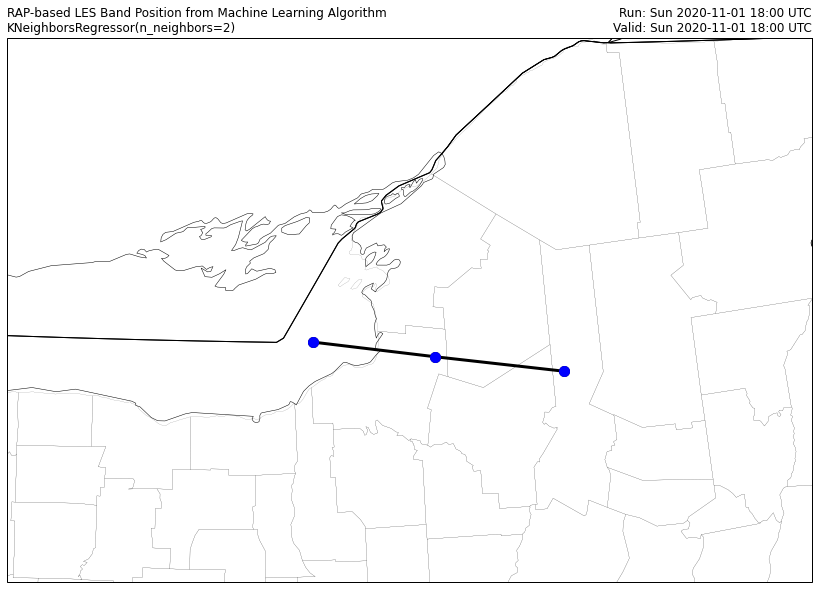

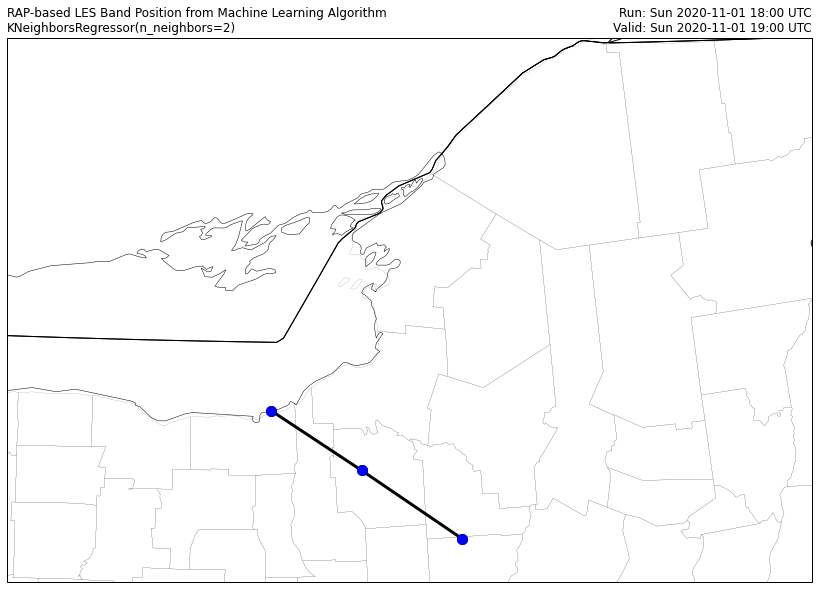

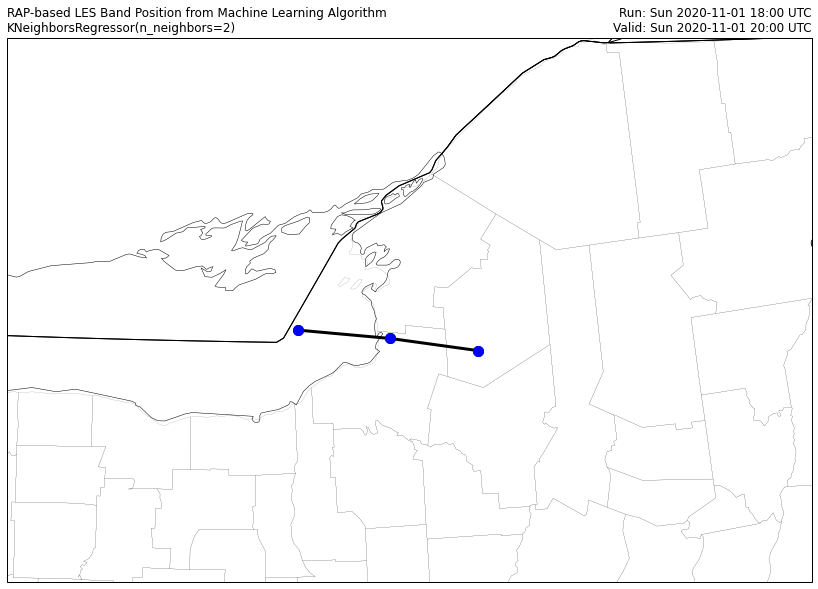

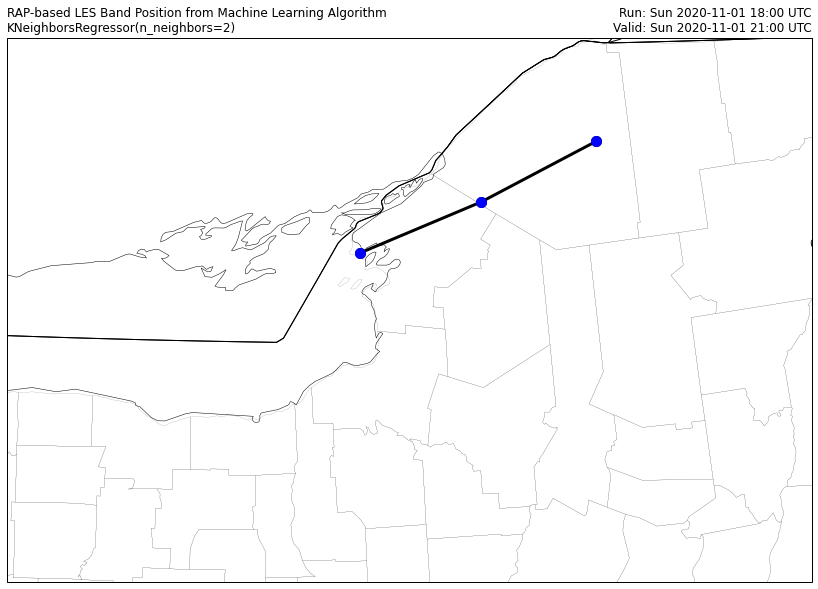

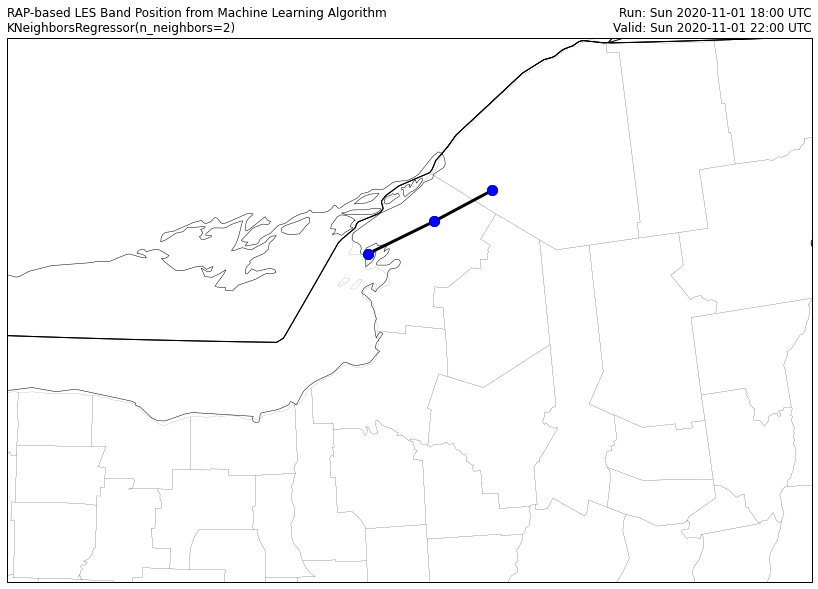

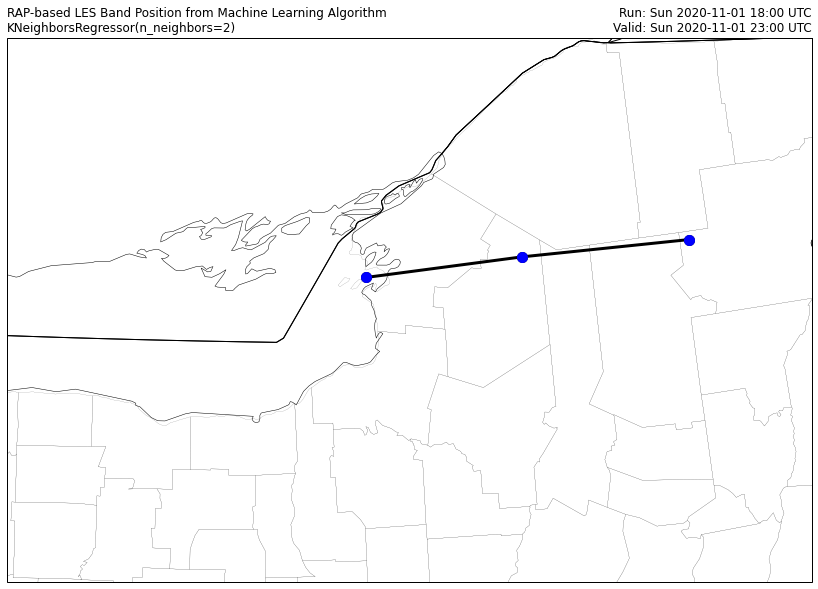

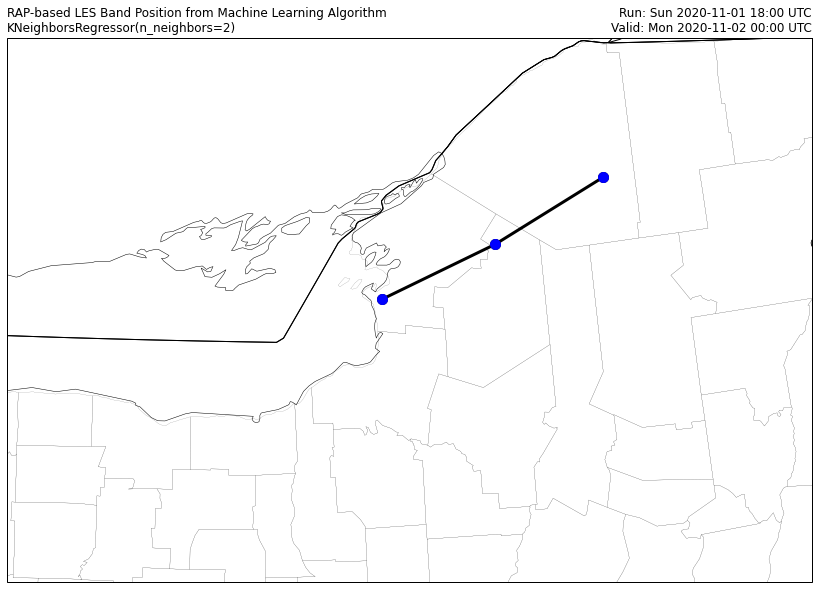

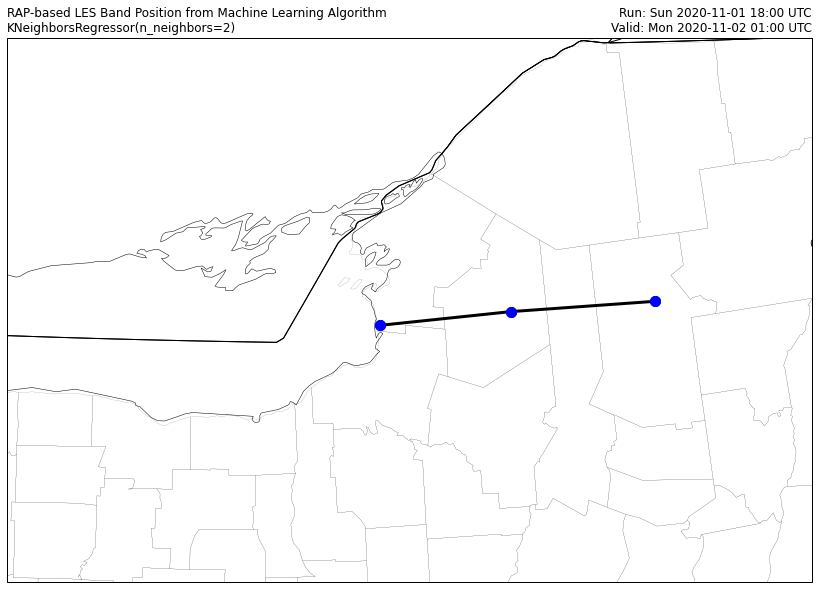

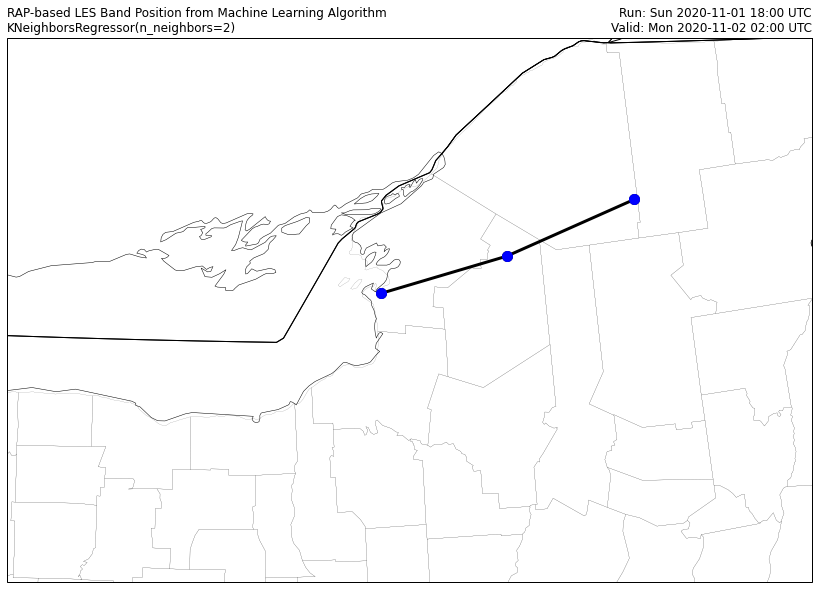

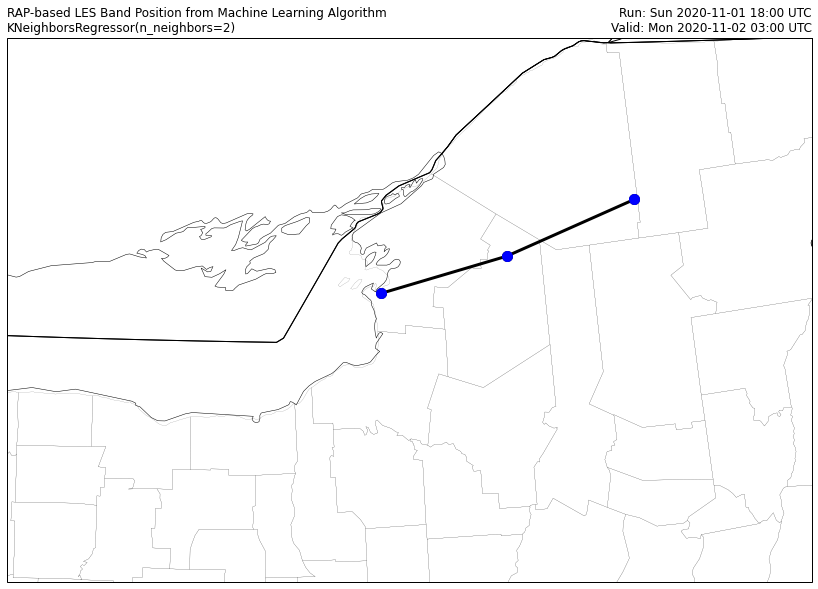

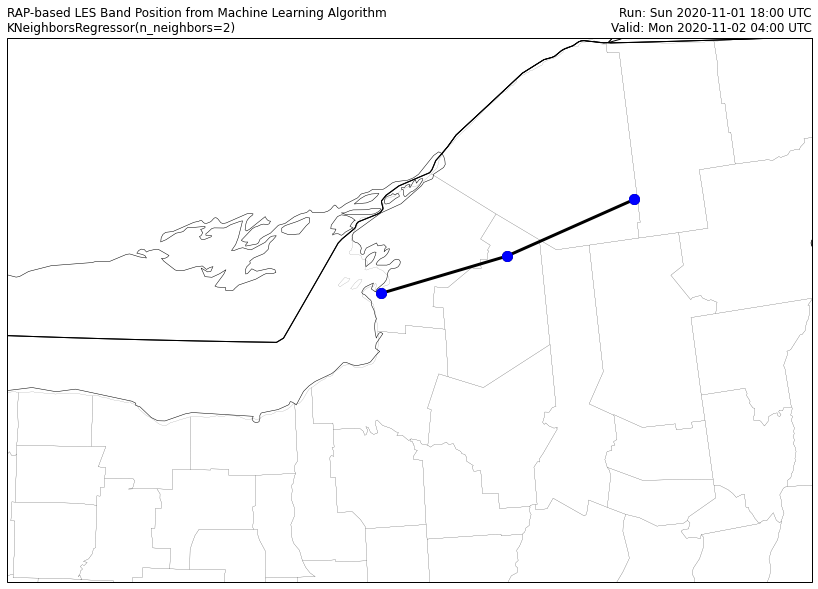

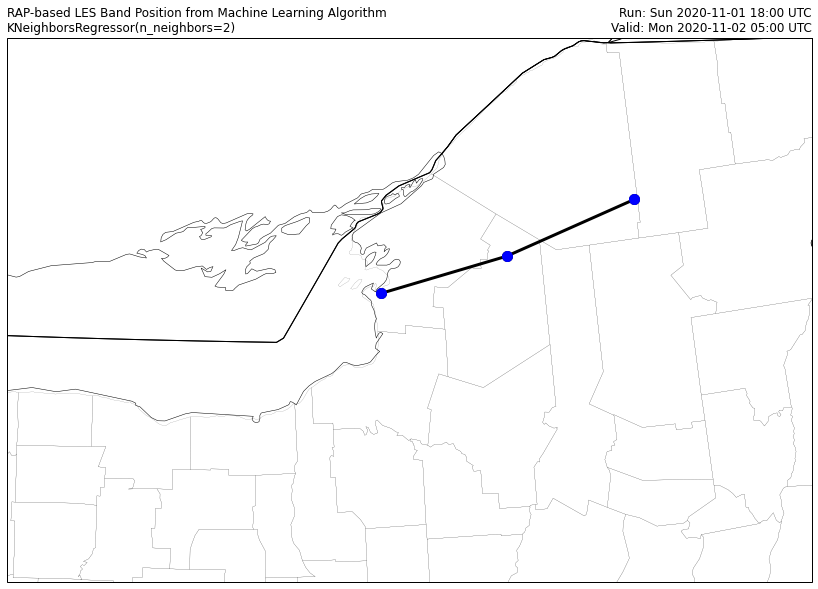

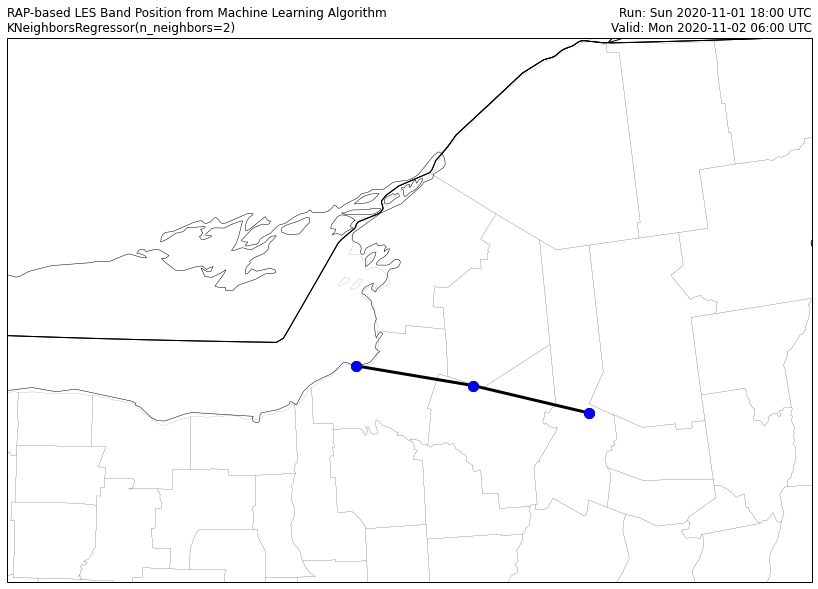

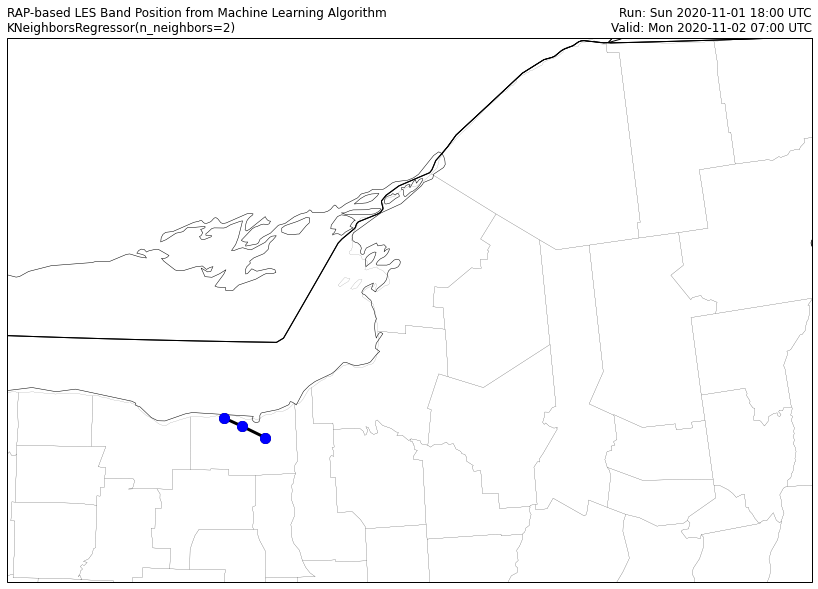

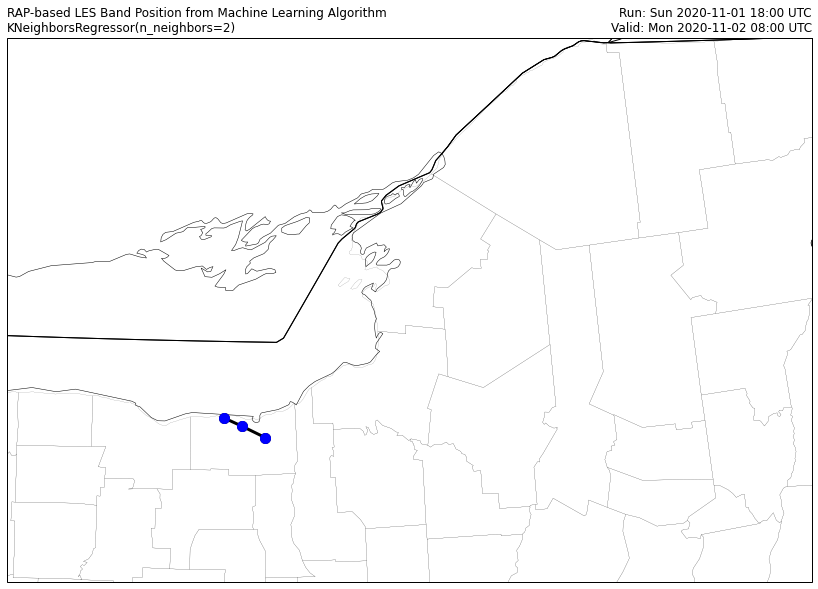

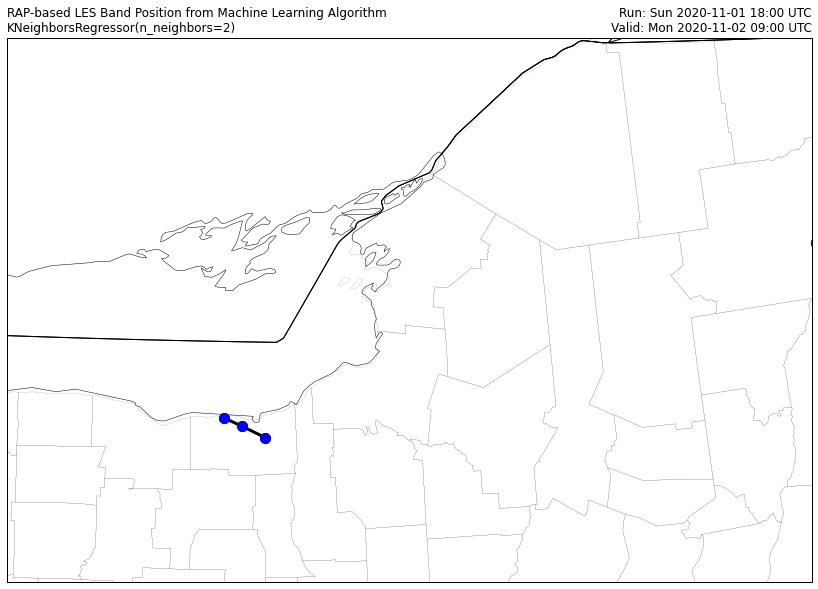

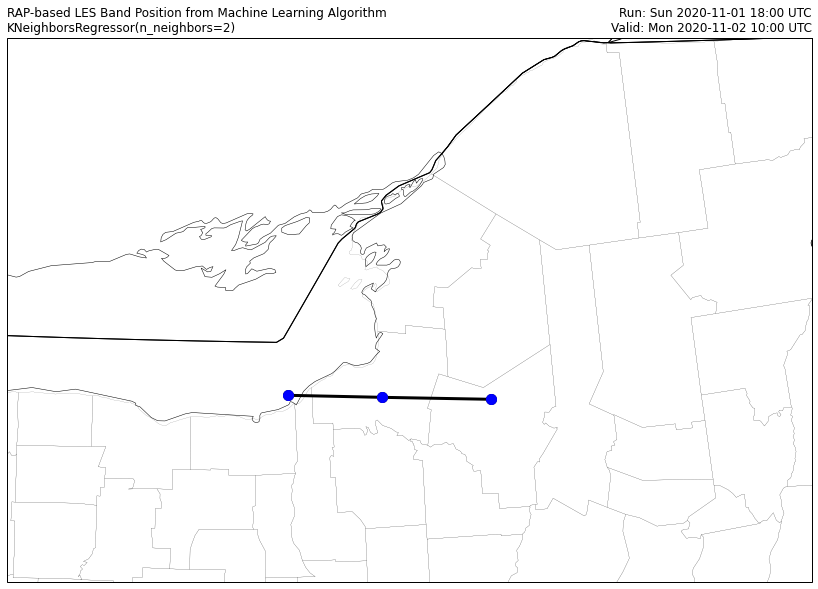

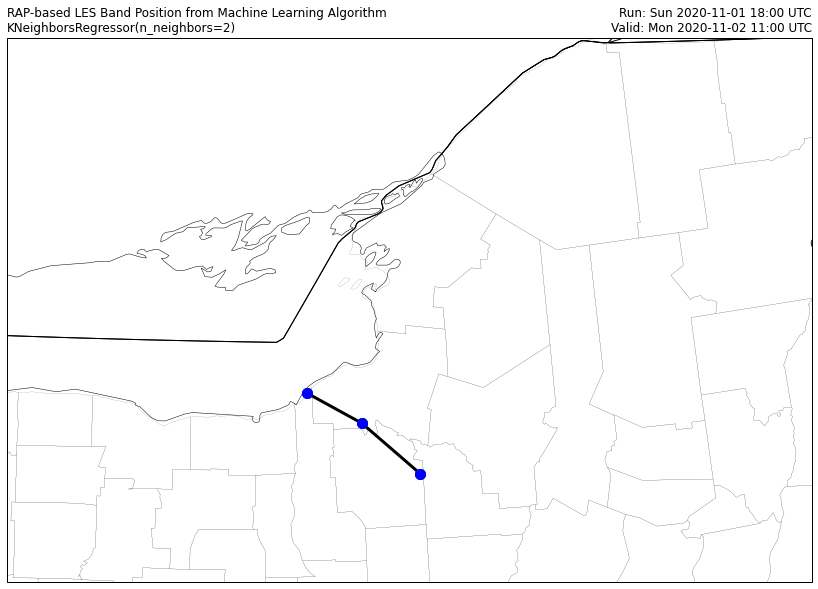

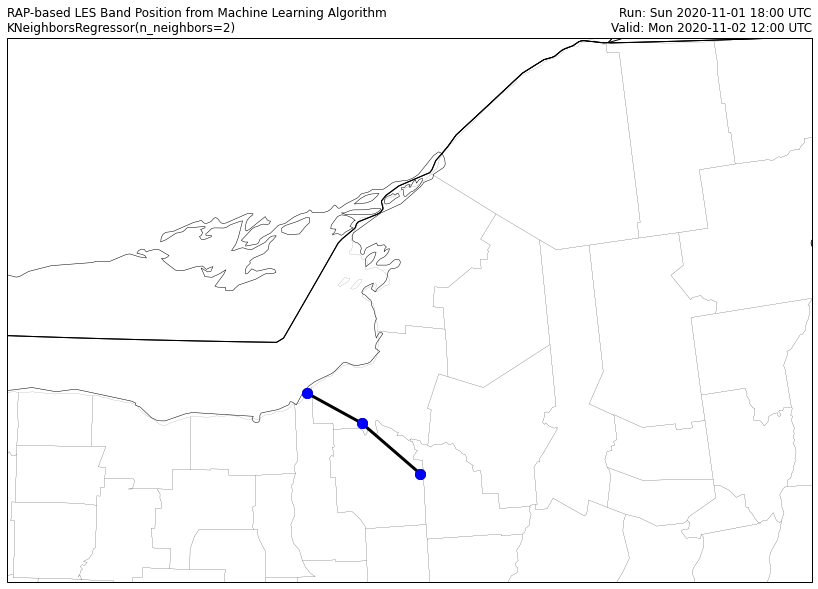

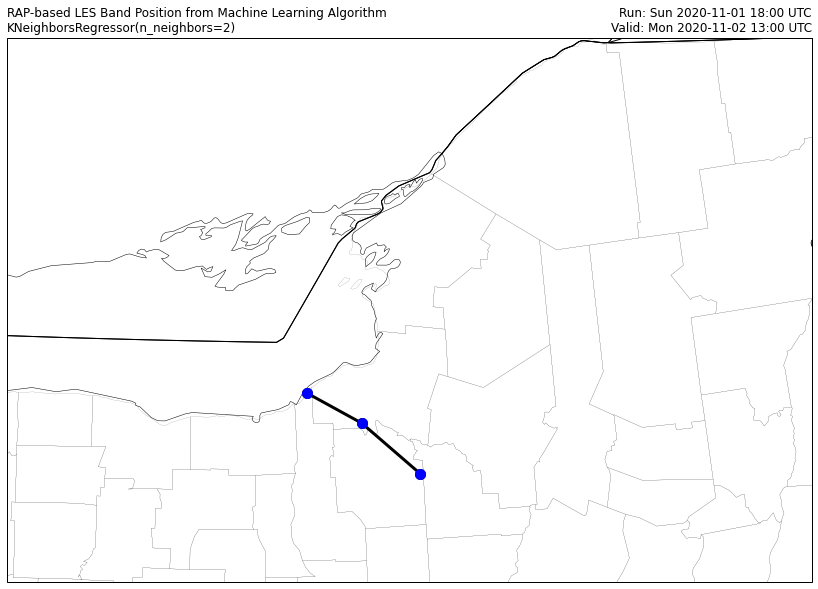

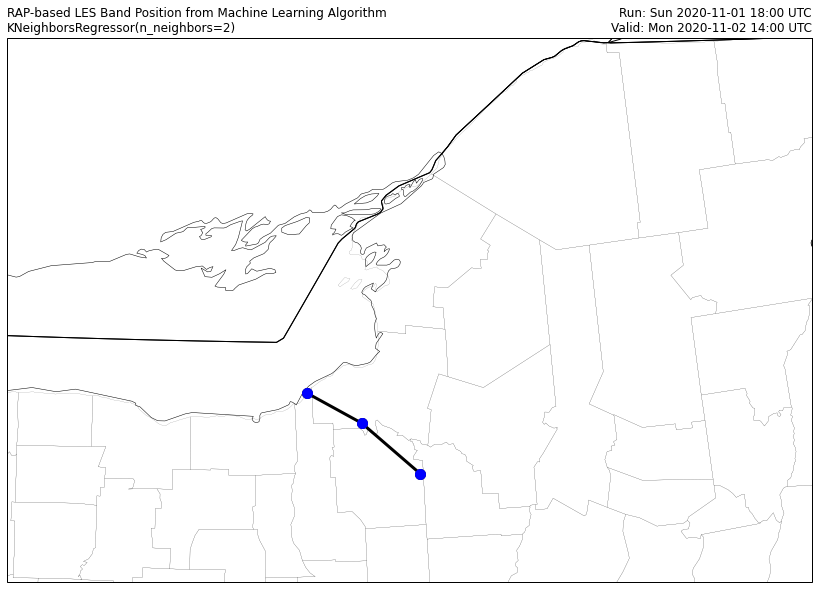

In [59]:
# Get maps for each frame
for (time, points) in zip(predictions.DateTime, predictions.values[:, 1:]):
    
    # Covenrt to LineString
    points = LineString(points)
    
    # Setup plot
    fig = plt.figure(figsize=(18, 10))

    # Generate Cartopy projections
    crs=ccrs.PlateCarree()
    domain=[-78.5, -73.5, 42.5, 45]
    proj = ccrs.Stereographic(central_longitude=(domain[1]-domain[0])/2+domain[0], central_latitude=(domain[3]-domain[2])/2+domain[2])
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(domain, crs=crs)

    # Plot line
    plt.plot(*points.xy, 'k', *points.xy, 'bo', marker='o', linewidth=3, markersize=10, transform=crs)

    # Add geographic features
    country_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
    ax.add_feature(country_borders, edgecolor='black', linewidth=1.0)
    state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)
    ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.1)

    # Add Headers
    rdate = predictions.DateTime[0]
    vdate = time
    plt.title(f'{model}-based LES Band Position from Machine Learning Algorithm\n{ai_model}', loc='left')
    plt.title(f'Run: {rdate.strftime("%a %Y-%m-%d %H:%M")} UTC\nValid: {vdate.strftime("%a %Y-%m-%d %H:%M")} UTC', loc='right')

    plt.show()